<a href="https://colab.research.google.com/github/muu86/ml_study/blob/main/SVM_%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM

* 선형 SVM ( 'LinearSVC , LinearSVR')
  * 직선을 투영하는 방식

* 비선형 SVM ( 커널 SVM)
  * 일반적인 SVM

  SV(Support Vector)를 훈련 시에 데이터와 포인트로부터 선정, 서포트 벡터의 개수와 범위를 지정하면서 복잡도를 조절한다.


In [1]:
!pip install mglearn

     |████████████████████████████████| 542kB 11.6MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=3f783c1f33d638a00d2946278205503cc654f9d1c1e8a04141a754a96e1523e9
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


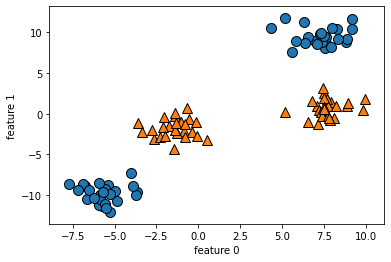

In [2]:
import mglearn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


X, y = make_blobs(centers=4, random_state=8)
y = y % 2 # 레이블 만들기

mglearn.discrete_scatter(X[:, 0], X[ :, 1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


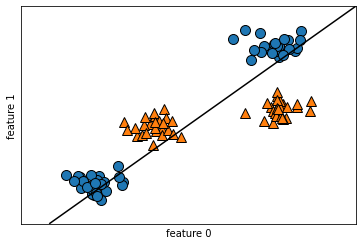

In [3]:
# 선형 모델 LinearSVC 이용해서 직선으로 결정경계 만들어보기

from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

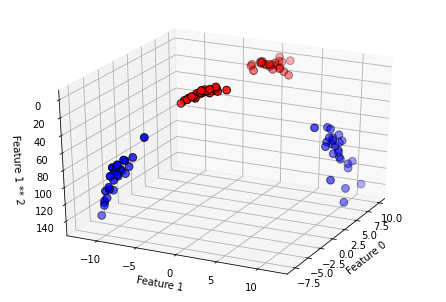

In [4]:
import numpy as np

X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)

# y == 0 인 포인트를 그리고 다음 y == 1 인 포인트를 그리기
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Feature 1 ** 2')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


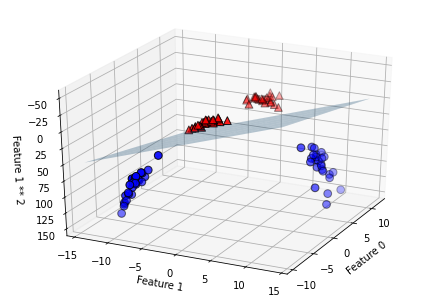

In [5]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")
plt.show()

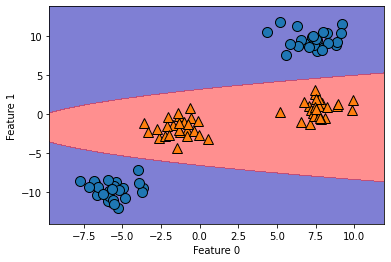

In [6]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels = [dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

위의 방식을 다차항 추가 기법이라고 한다.
실무에서는 어떠한 특성을 제곱하거나 세제곱 등을 해서 차원을 늘려갈지가 미지수..(분석을 통해 알아내야 한다.) 말도 안 되게 차원이 늘어갈 수도 있다 -> 데이터가 복잡해진다.

## 커널 SVM

수학적 기교를 사용하는 것이 아닌 커널 트릭( kernel trick )을 이용하는 방식

* RBF (radial basis function) : 가우시안 커널 $k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right)$

커널 SVM이 훈련 되면서 하는 일들
* SVM 모델이 배우는 것 : **훈련 데이터 포인트가 두 클래스 사이의 결정 경계를 구분하는데 얼마나 중요한지를 배운다.**
* 훈련 데이터의 일부만 결정 경계를 만드는데 영향을 미친다. **두 클래스 사이의 경계에 위치한 데이터 포인트**
* 이 데이터를 포인트를 **서포트 벡터(Support Vector)** 라고합니다.
* 가우시안 커널 폭의 거리는 최대 마진 거리로 만들어 진다.

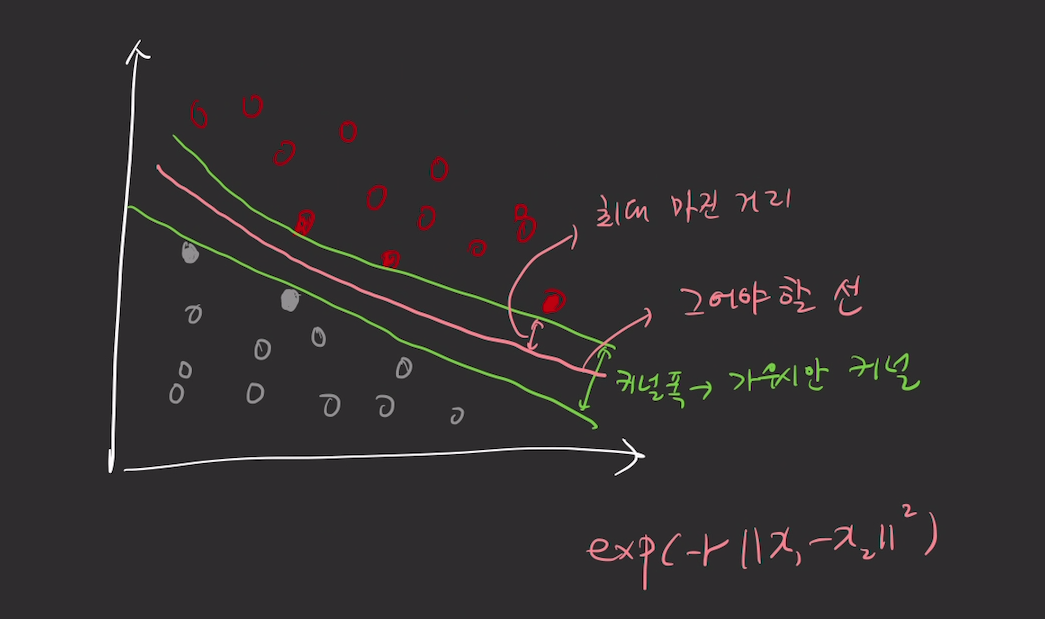

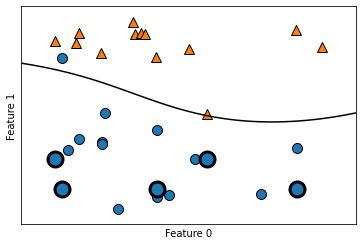

In [7]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel="rbf", C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

#서포트 벡터
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됨
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv_labels, s = 15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

## SVM 의 하이퍼 파라미터

* gamma
  * 가우시안 커널 폭의 **역수**
  * **gamma** 매개 변수가 하나의 훈련 샘플에 영향의 범위를 설정
  * gamma 가 커지면 -> 커널 폭 작아짐 -> 복잡도가 올라감
  * 연관성있는 데이터 포인트끼리의 모임을 만든다.
  * 우리끼리 모이자
* C
  * 서포트 벡터 선정에 영향을 미치는 규제 매개 변수
  * 각 데이터 포인트의 중요도 값을 제한한다.
  * 서포트 벡터 == 포인트 중요도
  * 포인트 중요도 : 서포트 벡터로써, 결정 경계를 구성하는데 어떠한 역할을 하는지 
  * C 가 커지면 -> 데이터 포인트 중요도 내려감, 억제, 제한 -> 서포트 벡터로 활용될 가능성 줄어듬 -> 선정되지 못 한 데이터 포인트 늘어남 -> 복잡도 증가
  * C 가 작아지면 -> 서포트 벡터로 선정된 데이터 포인트 늘어남 -> 전체적인 추세를 더 보게됨 -> 복잡도 감소

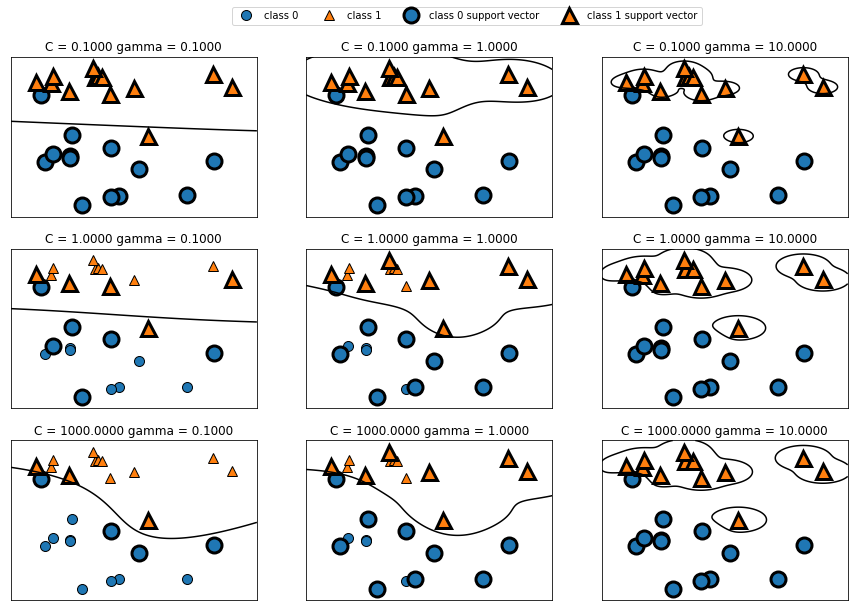

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]) :
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C = C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "class 0 support vector", "class 1 support vector"],
                  ncol=4, loc=(.9, 1.2))
plt.show()

## SVM 으로 유방암 데이터 처리하기

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print('훈련 세트 정확도 : {:.2f}'.format(svc.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.2f}'.format(svc.score(X_test, y_test)))

훈련 세트 정확도 : 0.90
테스트 세트 정확도 : 0.94


In [9]:
X_train

array([[1.185e+01, 1.746e+01, 7.554e+01, ..., 9.140e-02, 3.101e-01,
        7.007e-02],
       [1.122e+01, 1.986e+01, 7.194e+01, ..., 2.022e-02, 3.292e-01,
        6.522e-02],
       [2.013e+01, 2.825e+01, 1.312e+02, ..., 1.628e-01, 2.572e-01,
        6.637e-02],
       ...,
       [9.436e+00, 1.832e+01, 5.982e+01, ..., 5.052e-02, 2.454e-01,
        8.136e-02],
       [9.720e+00, 1.822e+01, 6.073e+01, ..., 0.000e+00, 1.909e-01,
        6.559e-02],
       [1.151e+01, 2.393e+01, 7.452e+01, ..., 9.653e-02, 2.112e-01,
        8.732e-02]])

SVM 주의사항
* 데이터 특성 사이의 스케일이 크면 잘 작동하지 않는다
  * MinMaxScale

* 데이터가 너무 많으면 X
  * 데이터가 적당한 크기일 때 사용